In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
import lime.lime_tabular_mod as lime_tab
import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
58,6.6,2.9,4.6,1.3,Iris-versicolor
45,4.8,3.0,1.4,0.3,Iris-setosa
54,6.5,2.8,4.6,1.5,Iris-versicolor
89,5.5,2.5,4.0,1.3,Iris-versicolor
77,6.7,3.0,5.0,1.7,Iris-versicolor
...,...,...,...,...,...
100,6.3,3.3,6.0,2.5,Iris-virginica
133,6.3,2.8,5.1,1.5,Iris-virginica
28,5.2,3.4,1.4,0.2,Iris-setosa
31,5.4,3.4,1.5,0.4,Iris-setosa


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LimeTabularExplainerMod(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

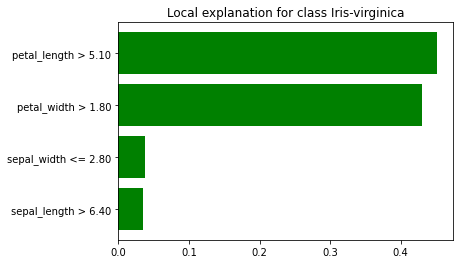

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[0.0, 0.0, 1.0]
[-0.04541329785885795, 0.015423098299428895, 1.0299901995594292]
[0.0, 0.014753112, 0.9852469]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.08073213 0.05544361 0.02716655]
MSE on cv-test  set: [0.08095571 0.0556049  0.02726196]
std on cv-test  set: [0.00156512 0.00153567 0.00199042]


In [11]:
explanation.get_losses_for_cv_model(out="raw")

array([[0.08223877, 0.08103081, 0.0804947 , 0.08274109, 0.07827318],
       [0.05683143, 0.05498491, 0.05581861, 0.0573766 , 0.05301297],
       [0.02848365, 0.03054967, 0.02642157, 0.02561478, 0.02524013]])

In [12]:
explanation.get_fidelity_loss_on_kfold("raw")

array([0.05583416, 0.05550861, 0.05423277, 0.05523092, 0.05214748])

In [13]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.45207910561458103),
 (3, 0.43071147898613327),
 (1, 0.03820011716166032),
 (0, 0.034443407673970715)]

In [14]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, -0.2674392232708202),
 (3, -0.18226682264171581),
 (0, -0.016744632588719006),
 (1, -0.009563183285312526)]

In [15]:
explanation.as_map()

{0: [(3, -0.24844465634441737),
  (2, -0.18463988234376072),
  (1, -0.028636933876347772),
  (0, -0.01769877508525171)],
 1: [(2, -0.2674392232708202),
  (3, -0.18226682264171581),
  (0, -0.016744632588719006),
  (1, -0.009563183285312526)],
 2: [(2, 0.45207910561458103),
  (3, 0.43071147898613327),
  (1, 0.03820011716166032),
  (0, 0.034443407673970715)]}

In [16]:
explainer.discretizer.names

{0: ['sepal_length <= 5.10',
  '5.10 < sepal_length <= 5.80',
  '5.80 < sepal_length <= 6.40',
  'sepal_length > 6.40'],
 1: ['sepal_width <= 2.80',
  '2.80 < sepal_width <= 3.00',
  '3.00 < sepal_width <= 3.30',
  'sepal_width > 3.30'],
 2: ['petal_length <= 1.60',
  '1.60 < petal_length <= 4.30',
  '4.30 < petal_length <= 5.10',
  'petal_length > 5.10'],
 3: ['petal_width <= 0.30',
  '0.30 < petal_width <= 1.30',
  '1.30 < petal_width <= 1.80',
  'petal_width > 1.80']}

In [17]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.3, 5.1, 6.7],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [18]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(2, 0.45207910561458103),
 (3, 0.43071147898613327),
 (1, 0.03820011716166032),
 (0, 0.034443407673970715)]